In [137]:
class isotonic_regression():
    '''
    Isotonic regression model.

    TO DO:
    - Does not properly work when y does not start at 0. 
    '''
    
    def __init__(self, breakpoints):
        self.breakpoints = breakpoints
        self.slopes = np.zeros(breakpoints)
        self.last_binvals = np.zeros(breakpoints+1)
        self.bins = None #set this on model.fit()

    
    def fit(self, x, y):
        # check inputs are the same length
        if len(x) != len(y):
            raise ValueError('x and y must be of the same length')

        ysum = y.min()
        last_binval = y.min()
        self.last_binvals[-1] = y.min()
        self.bins = np.linspace(x.min(), x.max(), num=self.breakpoints+1)

        for i in range(self.breakpoints):
            # Select points in the current bin
            bin_x = x[np.logical_and(x>self.bins[i], x<=self.bins[i+1])]
            if len(bin_x) < 1: # >= 1 data point in each bin.
                raise ValueError('Need at least 1 data point in each segment')

            # Select bin ys and shift bin starting x and starting y to 0,0
            bin_y = y[np.logical_and(x>self.bins[i], x<=self.bins[i+1]).flatten()]
            bin_y = bin_y - last_binval
            bin_x = bin_x - self.bins[i]

            # Find best fit line for the bin
            slope = self.OLS(bin_x, bin_y)
            self.slopes[i] = slope

            # Store the last value in the bin (to add onto next bin)
            last_binval = self.line(self.bins[1] - self.bins[0], slope, last_binval)
            self.last_binvals[i] = last_binval
            ysum += last_binval
    
        # plot fit model
        self.plot_model(x, y)

    def predict(self, x):
        preds = np.zeros(len(x))
        for i in range(len(x)):
            broke = False
            x_raw = x[i] - self.bins[0]
            if x[i] <= self.bins[0]:
                preds[i] = self.last_binvals[-1]
                continue
            else:
                for j in range(len(self.bins)-1):
                    if x[i] > self.bins[j] and x[i] < self.bins[j+1]:
                        preds[i] = self.line(x_raw, self.slopes[j], self.last_binvals[j-1])
                        broke = True
                        break
                    else:
                        x_raw -= self.bins[1] - self.bins[0]
                if broke == False:
                    preds[i] = self.line(x_raw, self.slopes[j], self.last_binvals[j])
        return preds
    
    @staticmethod
    def line(x, slope, intercept):
        return slope*x + intercept

    @staticmethod
    def OLS(x, y):
        x = x.reshape(-1,1)
        xTx = x.T.dot(x)
        xTx_inv = np.linalg.inv(xTx)
        slope = xTx_inv.dot(x.T.dot(y))
        return max(np.asarray([0]), slope)
    
    def plot_model(self, x, y):
        # Technically I may be able to just plot breakpoints and connect them.
        modelx = np.arange(x.min(), x.max(), 0.23)
        modely = self.predict(modelx)

        plt.scatter(modelx, modely, s=5, color='tab:orange')
        plt.scatter(x, y)

        for i in range(len(self.bins)):
            plt.axvline(x = self.bins[i], alpha=0.2)
        plt.show()

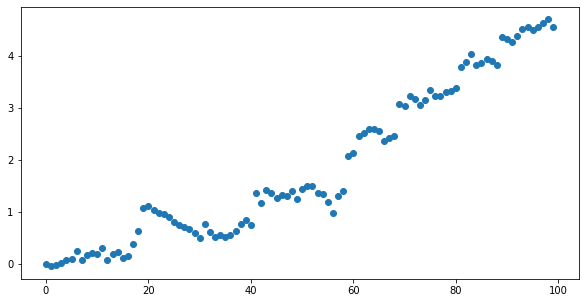

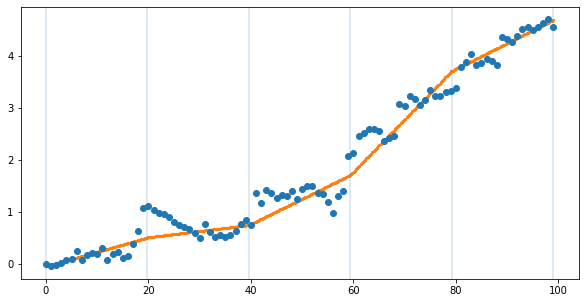

In [138]:
import numpy as np
import matplotlib.pyplot as plt

# from regressio.models import linear_regression
from regressio.datagen import generate_isotonic_sample

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 5)

n = 100
np.random.seed(2)

x, y = generate_isotonic_sample(n, plot=True)
model = isotonic_regression(5)
model.fit(x, y)